/Users/sarayabesi/Documents/research-poly/eye-tracker-project/machine_learning/dataset_2
Logistic Regression - Cross-Validation ROC-AUC Scores: [0.36875    0.36532508 0.28453947 0.45723684 0.37171053]
Logistic Regression - Mean ROC-AUC Score: 0.3695123839009288
Logistic Regression - Test Set Performance:
Accuracy: 0.5111111111111111
Precision: 0.5
Recall: 0.9545454545454546
F1-Score: 0.65625
ROC-AUC: 0.46936758893280633


Random Forest - Cross-Validation ROC-AUC Scores: [0.559375   0.32817337 0.34046053 0.72368421 0.53289474]
Random Forest - Mean ROC-AUC Score: 0.49691756965944267
Random Forest - Test Set Performance:
Accuracy: 0.4888888888888889
Precision: 0.4838709677419355
Recall: 0.6818181818181818
F1-Score: 0.5660377358490567
ROC-AUC: 0.4871541501976284


Gradient Boosting - Cross-Validation ROC-AUC Scores: [0.575      0.27863777 0.26809211 0.73026316 0.56578947]
Gradient Boosting - Mean ROC-AUC Score: 0.48355650154798757
Gradient Boosting - Test Set Performance:
Accuracy: 0.53333

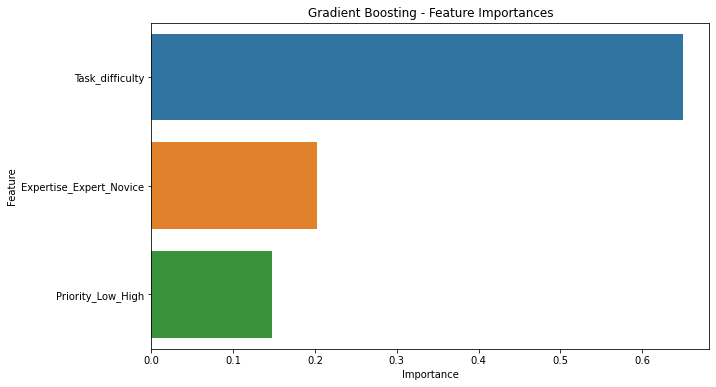

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import os 
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
main_dir = os.getcwd()
print(main_dir)

# Load your dataset
file_path = os.path.join(main_dir, "dataset_2.csv")
df = pd.read_csv(file_path)

# Features and target
X = df[['Task_difficulty', 'Priority_Low_High', 'Expertise_Expert_Novice']]
y = df['is_accepted']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ['Task_difficulty']
numeric_transformer = StandardScaler()

categorical_features = ['Priority_Low_High', 'Expertise_Expert_Novice']
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True)
}

# Function to get feature importances
def get_feature_importances(model, feature_names):
    if isinstance(model, LogisticRegression) or isinstance(model, SVC):
        # For linear models, get coefficients
        importances = model.coef_[0]
    elif isinstance(model, RandomForestClassifier) or isinstance(model, GradientBoostingClassifier):
        # For tree-based models, get feature importances
        importances = model.feature_importances_
    else:
        return None
    
    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    return feature_importances.sort_values(by='Importance', ascending=False)

# Train and evaluate models with 5-fold cross-validation
feature_names = ['Task_difficulty'] + ['Priority_Low_High', 'Expertise_Expert_Novice']  # After one-hot encoding
best_accuracy = 0
best_model = None
best_model_name = ""

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"{name} - Cross-Validation ROC-AUC Scores: {cv_scores}")
    print(f"{name} - Mean ROC-AUC Score: {cv_scores.mean()}")

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Test Set Performance:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1-Score: {f1_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clf
        best_model_name = name
    
    print("\n")

# Get feature importances for the best model
if best_model is not None:
    print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy}")
    feature_importances = get_feature_importances(best_model.named_steps['classifier'], feature_names)
    if feature_importances is not None:
        print(f"{best_model_name} - Feature Importances:")
        print(feature_importances)
        
        # Plotting feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importances)
        plt.title(f'{best_model_name} - Feature Importances')
        plt.show()
